<a href="https://colab.research.google.com/github/thirayume/muangtai/blob/main/Muangtai_PO_Prediction_Days.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **V.1 - Muangtai Purchasing Prediction by Day**

In [ ]:
# @title Define secrets

from google.colab import userdata
host = userdata.get('host')
port = userdata.get('port')
database = userdata.get('database')
user = userdata.get('user')
password = userdata.get('password')

In [ ]:
# @title Install dependencies (if need)

!pip install psycopg2 pandas pmdarima

In [ ]:
# @title Import dependencies

import psycopg2

from datetime import datetime

import numpy as np
import pandas as pd
from pandas import plotting

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
import seaborn as sns

import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected = True)

import fastai

import warnings
import os
from pathlib import Path
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.autograd import Variable

import pmdarima as pm

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from math import sqrt

# plt.style.use('fivethirtyeight')
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout = True)
plt.rc("axes", labelweight = "bold", labelsize = "large", titleweight = "bold", titlesize = 12, titlepad = 10)

In [ ]:
# @title Connect to the PostgreSQL database

conn = psycopg2.connect(
    host=host,
    port=port,
    database=database,
    user=user,
    password=password,
)
conn

In [ ]:
# @title Define a SQL to create a "view_picking_list" (if not found)

sql = """
      -- STEP 1: create function "multiply_hierarchy_unit_quantity function"
      CREATE OR REPLACE FUNCTION multiply_hierarchy_unit_quantity(start_stock_keeping_unit_id uuid)
      RETURNS numeric AS $$
      DECLARE is_base_unit bool = false;
      DECLARE total numeric(12,8) = 1;
      BEGIN

          SELECT a.is_base_unit INTO is_base_unit FROM dim_stock_keeping_units a where a.id = start_stock_keeping_unit_id;

          if is_base_unit then
              SELECT 1 INTO total FROM dim_bill_of_materials where stock_keeping_unit_id = start_stock_keeping_unit_id;
          else
              WITH RECURSIVE unit_cte AS (
                  SELECT stock_keeping_unit_id, part_id, multiplier
                  FROM dim_bill_of_materials
                  where stock_keeping_unit_id = start_stock_keeping_unit_id
                  UNION ALL
                  SELECT h.stock_keeping_unit_id, h.part_id, h.multiplier
                  FROM dim_bill_of_materials h
                  INNER JOIN unit_cte cte ON h.stock_keeping_unit_id = cte.part_id
              )
              SELECT product(multiplier) INTO total FROM unit_cte;
          end if;
          RETURN total;
      END;
      $$ LANGUAGE plpgsql;

      -- Helper function to calculate product in a recursive query
      CREATE AGGREGATE product(numeric) (
          SFUNC = numeric_mul,
          STYPE = numeric,
          INITCOND = '1'
      );

      -- Multiplication function
      CREATE OR REPLACE FUNCTION numeric_mul(numeric, numeric)
      RETURNS numeric AS $$
      BEGIN
          RETURN $1 * $2;
      END;
      $$ LANGUAGE plpgsql;

      ----------------------
      -- STEP 2: Create view "view_dim_picking_lists_lasted_updated_at"
      DROP VIEW IF EXISTS view_dim_picking_lists_lasted_updated_at;

      CREATE OR REPLACE VIEW view_dim_picking_lists_lasted_updated_at
      AS
      select id,
          CASE
              WHEN a.document_date < (a.moderated_at::date)
                  THEN (a.document_date + '08:30:01'::time)
              -- IN CASE a.document_date >= a.moderated.date
              WHEN a.moderated_at is null and a.document_date is not null
                  THEN (a.document_date + '08:30:01'::time)
              WHEN a.moderated_at is null and a.document_date is null
                  THEN a.updated_at
              ELSE a.moderated_at
          END as date
      from dim_picking_lists a
      where moderation_status = 1;

      ----------------------
      -- create view "view_fact_picking_lists"
      DROP VIEW IF EXISTS view_fact_picking_lists;

      CREATE OR REPLACE VIEW view_fact_picking_lists
      AS

      select
      fact_picking_lists.id as fact_picking_lists__id
      ,to_char(view_dim_picking_lists_lasted_updated_at.date ::date, 'YYYY-MM-DD' ) as dim_pickinglists__document_date
      ,to_char(view_dim_picking_lists_lasted_updated_at.date ::time, 'HH24:MI:SS' ) as dim_pickinglists__document_time
      ,dim_picking_lists.document_number as dim_picking_lists__document_number
      ,dim_picking_lists.id as dim_picking_lists__id
      ,dim_stock_keeping_units.id as dim_stock_keeping_units__sku_id
      ,fact_picking_lists.quantity as fact_picking_lists__quantity
      , (fact_picking_lists.quantity  * multiply_hierarchy_unit_quantity(fact_picking_lists.stock_keeping_unit_id)) as liters
      ,dim_families.is_alcoholic as dim_families__is_alcoholic
      ,dim_picking_lists.owner_id as dim_picking_lists__owner_id
      ,dim_picking_lists.owner_type as dim_picking_lists__owner_type
      from		fact_picking_lists
      inner join	dim_dates on dim_dates.id = fact_picking_lists.date_id
      inner join	dim_times on dim_times.id = fact_picking_lists.time_id
      inner join	dim_families on dim_families.id = fact_picking_lists.family_id
      inner join	dim_brands on dim_brands.id = dim_families.brand_id
      inner join 	dim_picking_lists on dim_picking_lists.id = fact_picking_lists.picking_list_id
      inner join 	dim_stock_keeping_units on dim_stock_keeping_units.id = fact_picking_lists.stock_keeping_unit_id
      inner join  view_dim_picking_lists_lasted_updated_at on dim_picking_lists.id = view_dim_picking_lists_lasted_updated_at.id
      where fact_picking_lists.deleted_at is null
      and dim_picking_lists.moderation_status = 1 -- Approved
      and fact_picking_lists.direction = 'outbound'
      order by  fact_picking_lists.id desc;
      """

In [ ]:
# @title Define a SQL query to select data from a "fact_picking_lists" like in a View

sql = """
      select * from view_fact_picking_lists;
      """

In [ ]:
# @title Create a cursor object to execute queries to dataframe

with conn.cursor() as cursor:
  # Execute the query
  cursor.execute(sql)
  columns = [desc[0] for desc in cursor.description]
  # Fetch all rows from the query result
  rows = cursor.fetchall()

  # Create dataframe
  df = pd.DataFrame(rows, columns=columns)

In [ ]:
# @title Close the connection
conn.close()

In [ ]:
# @title Mount Google Drive (if need)

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# @title Save to csv for local work

# Define data path
data_path = Path('/content/drive/MyDrive/Colab Notebooks/Muangtai')
%cd {data_path}

# Convert the DataFrame to a dictionary with lists as values
data_dict = df.to_dict(orient="list")

# Specify the output file path
output_file = data_path/"output.csv"

# Write the query result to CSV
df.to_csv(output_file)

# Read CSV from local
output_file = data_path/"output.csv"
df = pd.read_csv(output_file)

In [273]:
# @title Read CSV from local

output_file = data_path/"output.csv"
df = pd.read_csv(output_file)

In [274]:
df.head()

,Unnamed: 0,fact_picking_lists__id,dim_pickinglists__document_date,dim_pickinglists__document_time,dim_picking_lists__document_number,dim_picking_lists__id,dim_stock_keeping_units__sku_id,fact_picking_lists__quantity,liters,dim_families__is_alcoholic,dim_picking_lists__owner_id,dim_picking_lists__owner_type
0,0,9c5049c5-2dd6-489b-a7e8-5466ea03d768,2024-06-18,11:54:49,78401,9c5049c5-1a13-4e13-a702-272b9619c341,86668666-8666-8666-8666-866686668666,35,206,True,43666aa9-17ca-4b2e-870d-79ef49d6be33,App\Models\Syndicate
1,1,9c5049c5-2afa-402d-aeca-f5d9cb5c361c,2024-06-18,11:54:49,78401,9c5049c5-1a13-4e13-a702-272b9619c341,3e44aa10-5b8f-4954-853d-b92878123bf9,9,70,NaN,43666aa9-17ca-4b2e-870d-79ef49d6be33,App\Models\Syndicate
2,2,9c5049c5-27fc-4663-ab8f-bb9d6b14897f,2024-06-18,11:54:49,78401,9c5049c5-1a13-4e13-a702-272b9619c341,84848484-8484-8484-8484-848484848484,100,588,True,43666aa9-17ca-4b2e-870d-79ef49d6be33,App\Models\Syndicate
3,3,9c5049c5-2526-44e3-a666-927554ff3f59,2024-06-18,11:54:49,78401,9c5049c5-1a13-4e13-a702-272b9619c341,77767776-7776-7776-7776-777677767776,5,37,True,43666aa9-17ca-4b2e-870d-79ef49d6be33,App\Models\Syndicate
4,4,9c5049c5-2276-46a1-a08c-980a8fa97d31,2024-06-18,11:54:49,78401,9c5049c5-1a13-4e13-a702-272b9619c341,87878787-8787-8787-8787-878787878787,40,307,True,43666aa9-17ca-4b2e-870d-79ef49d6be33,App\Models\Syndicate


In [275]:
# @title Format Date and Time and Index

df['podatetime'] = pd.to_datetime( df['dim_pickinglists__document_date']  + ' ' + df['dim_pickinglists__document_time'], infer_datetime_format=True)
df['dim_pickinglists__document_date'] = pd.to_datetime(df['dim_pickinglists__document_date'], infer_datetime_format = True)
df['podatetime'] = pd.to_datetime(df['podatetime'], infer_datetime_format = True)

In [276]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [277]:
df.head()

,fact_picking_lists__id,dim_pickinglists__document_date,dim_pickinglists__document_time,dim_picking_lists__document_number,dim_picking_lists__id,dim_stock_keeping_units__sku_id,fact_picking_lists__quantity,liters,dim_families__is_alcoholic,dim_picking_lists__owner_id,dim_picking_lists__owner_type,podatetime
0,9c5049c5-2dd6-489b-a7e8-5466ea03d768,2024-06-18,11:54:49,78401,9c5049c5-1a13-4e13-a702-272b9619c341,86668666-8666-8666-8666-866686668666,35,206,True,43666aa9-17ca-4b2e-870d-79ef49d6be33,App\Models\Syndicate,2024-06-18 11:54:49
1,9c5049c5-2afa-402d-aeca-f5d9cb5c361c,2024-06-18,11:54:49,78401,9c5049c5-1a13-4e13-a702-272b9619c341,3e44aa10-5b8f-4954-853d-b92878123bf9,9,70,NaN,43666aa9-17ca-4b2e-870d-79ef49d6be33,App\Models\Syndicate,2024-06-18 11:54:49
2,9c5049c5-27fc-4663-ab8f-bb9d6b14897f,2024-06-18,11:54:49,78401,9c5049c5-1a13-4e13-a702-272b9619c341,84848484-8484-8484-8484-848484848484,100,588,True,43666aa9-17ca-4b2e-870d-79ef49d6be33,App\Models\Syndicate,2024-06-18 11:54:49
3,9c5049c5-2526-44e3-a666-927554ff3f59,2024-06-18,11:54:49,78401,9c5049c5-1a13-4e13-a702-272b9619c341,77767776-7776-7776-7776-777677767776,5,37,True,43666aa9-17ca-4b2e-870d-79ef49d6be33,App\Models\Syndicate,2024-06-18 11:54:49
4,9c5049c5-2276-46a1-a08c-980a8fa97d31,2024-06-18,11:54:49,78401,9c5049c5-1a13-4e13-a702-272b9619c341,87878787-8787-8787-8787-878787878787,40,307,True,43666aa9-17ca-4b2e-870d-79ef49d6be33,App\Models\Syndicate,2024-06-18 11:54:49


In [278]:
df.tail()

,fact_picking_lists__id,dim_pickinglists__document_date,dim_pickinglists__document_time,dim_picking_lists__document_number,dim_picking_lists__id,dim_stock_keeping_units__sku_id,fact_picking_lists__quantity,liters,dim_families__is_alcoholic,dim_picking_lists__owner_id,dim_picking_lists__owner_type,podatetime
32212,9901db83-6293-4c12-9b7a-827aa7da04ce,2023-03-01,08:30:01,71478,9901db82-9a86-41fc-b254-7c1f432057ed,ea38bd0c-ade6-4ce2-95d5-394fef052abc,1,1,NaN,43666aa9-17ca-4b2e-870d-79ef49d6be33,App\Models\Syndicate,2023-03-01 08:30:01
32213,9901db82-f902-4fcd-b589-516b617bf046,2023-03-01,08:30:01,71478,9901db82-9a86-41fc-b254-7c1f432057ed,15151515-1515-1515-1515-151515151515,5,150,True,43666aa9-17ca-4b2e-870d-79ef49d6be33,App\Models\Syndicate,2023-03-01 08:30:01
32214,9900b1c6-f580-4ae7-a6fc-91724247f8ad,2023-02-27,08:30:01,71477,9900b1c6-85ec-4bfe-8ccc-4ad9bd9bb522,15151515-1515-1515-1515-151515151515,1,30,True,43666aa9-17ca-4b2e-870d-79ef49d6be33,App\Models\Syndicate,2023-02-27 08:30:01
32215,9900b143-731c-41b3-952f-e3ef02565a2e,2023-02-27,08:30:01,71476,9900b143-0ec9-4979-b527-e6f95b9900fd,73337333-7333-7333-7333-733373337333,"1,000","7,440",True,43666aa9-17ca-4b2e-870d-79ef49d6be33,App\Models\Syndicate,2023-02-27 08:30:01
32216,9900b057-1c02-4dae-882b-32cb6b1e204b,2023-02-27,08:30:01,71475,9900b056-aa8f-45a0-8f47-937095ef3511,61616161-6161-6161-6161-616161616161,2,18,NaN,43666aa9-17ca-4b2e-870d-79ef49d6be33,App\Models\Syndicate,2023-02-27 08:30:01


In [279]:
df.describe()

,dim_pickinglists__document_date,dim_picking_lists__document_number,fact_picking_lists__quantity,liters,podatetime
count,32217,"32,217","32,217","32,162",32217
mean,2023-10-27 11:05:16.118819328,"75,008",39,300,2023-10-27 21:54:30.007014912
min,2022-04-11 00:00:00,"71,475",1,0,2022-04-11 08:30:01
25%,2023-06-28 00:00:00,"73,306",4,29,2023-06-28 09:32:35
50%,2023-11-01 00:00:00,"75,027",10,78,2023-11-01 08:30:01
75%,2024-02-27 00:00:00,"76,719",30,252,2024-02-27 15:48:38
max,2024-06-18 00:00:00,"78,401","2,000","14,880",2024-06-18 11:54:49
std,NaN,"1,989",95,719,NaN


In [280]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32217 entries, 0 to 32216
Data columns (total 12 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   fact_picking_lists__id              32217 non-null  object        
 1   dim_pickinglists__document_date     32217 non-null  datetime64[ns]
 2   dim_pickinglists__document_time     32217 non-null  object        
 3   dim_picking_lists__document_number  32217 non-null  int64         
 4   dim_picking_lists__id               32217 non-null  object        
 5   dim_stock_keeping_units__sku_id     32217 non-null  object        
 6   fact_picking_lists__quantity        32217 non-null  float64       
 7   liters                              32162 non-null  float64       
 8   dim_families__is_alcoholic          18255 non-null  object        
 9   dim_picking_lists__owner_id         32217 non-null  object        
 10  dim_picking_lists__own

In [281]:
df.isnull().sum()

fact_picking_lists__id                    0
dim_pickinglists__document_date           0
dim_pickinglists__document_time           0
dim_picking_lists__document_number        0
dim_picking_lists__id                     0
dim_stock_keeping_units__sku_id           0
fact_picking_lists__quantity              0
liters                                   55
dim_families__is_alcoholic            13962
dim_picking_lists__owner_id               0
dim_picking_lists__owner_type             0
podatetime                                0
dtype: int64

In [282]:
# Fill NaN with False for this column
df['dim_families__is_alcoholic'] = df['dim_families__is_alcoholic'].notna()

In [283]:
# Clean all null value
df1 = df.copy()
df1 = df1.drop(['liters'], axis=1)
df1.isnull().sum()

fact_picking_lists__id                0
dim_pickinglists__document_date       0
dim_pickinglists__document_time       0
dim_picking_lists__document_number    0
dim_picking_lists__id                 0
dim_stock_keeping_units__sku_id       0
fact_picking_lists__quantity          0
dim_families__is_alcoholic            0
dim_picking_lists__owner_id           0
dim_picking_lists__owner_type         0
podatetime                            0
dtype: int64

In [284]:
# Drop some data
mindate = datetime.datetime(2023, 4, 24)

df1 = df1[df1.dim_pickinglists__document_date > mindate]

In [285]:
sku_ids = df1['dim_stock_keeping_units__sku_id'].unique()
print(sorted(sku_ids))

['01670074-7124-4d8c-a5ea-83ae2e8fbe71', '0651ff55-0b29-4347-9860-7c4adc5dcb50', '06964cbe-9724-4331-aac9-a5d10787d0d9', '085673b7-a440-45d4-9167-c2fdb756b2b1', '0979879a-c604-441d-afa2-91b8c68e7fc1', '0acff31b-921d-4b59-aae6-813bb9362aee', '0bd166f5-82d6-4706-ac78-228656506a72', '10fb438f-26d5-4598-bde7-490a7b6ccceb', '12242ad2-dd75-4e84-89e8-0e6123eb68b5', '12bcb219-cae0-4eed-8756-d535fe4acce4', '13131313-1313-1313-1313-131313131313', '15151515-1515-1515-1515-151515151515', '1666da92-e315-464e-bef8-ed9da70d67ff', '17171717-1717-1717-1717-171717171717', '18181818-1818-1818-1818-181818181818', '1e6277a0-bd66-44a0-b746-9eb97b29bfcd', '2328e46a-fb09-4d75-a526-e16659a11b3f', '238c52f0-6573-4a53-b51b-d90eb304c745', '2f4cabd0-e857-457a-9f58-61c1146f94ff', '30e6cd3d-146b-4c61-bac2-edccb5c5b373', '317cf546-c60b-4b81-aff1-90c3f812eb19', '31e6ab18-1131-45c2-b26f-3d06d4169549', '33333333-3333-3333-3333-333333333333', '35796a6d-ca54-4b49-bc45-c878410677b6', '37042d15-5858-4705-a664-d5c2f26f7744',

In [286]:
# @title Pivot SKU Sales by Month
pd.set_option("display.float_format", "{:,.0f}".format)

df1['dim_pickinglists__document_date'] = pd.to_datetime(df1['dim_pickinglists__document_date'], infer_datetime_format = True)

pivot_df1 = df1.pivot_table(
    values='fact_picking_lists__quantity',
    index=['dim_stock_keeping_units__sku_id'],
    columns=['dim_pickinglists__document_date'],
    aggfunc='sum',
    margins = True,
    fill_value = '0'
)
pivot_df1 = pivot_df1.sort_values(by=['All'], ascending=False)
pivot_df1

dim_pickinglists__document_date,2023-04-25 00:00:00,2023-04-26 00:00:00,2023-04-27 00:00:00,2023-04-28 00:00:00,2023-04-29 00:00:00,2023-05-02 00:00:00,2023-05-03 00:00:00,2023-05-04 00:00:00,2023-05-05 00:00:00,2023-05-06 00:00:00,...,2024-06-08 00:00:00,2024-06-10 00:00:00,2024-06-11 00:00:00,2024-06-12 00:00:00,2024-06-13 00:00:00,2024-06-14 00:00:00,2024-06-15 00:00:00,2024-06-17 00:00:00,2024-06-18 00:00:00,All
dim_stock_keeping_units__sku_id,,,,,,,,,,,,,,,,,,,,,
All,"2,371","3,526","2,315","4,612","5,375","4,543","3,627","4,333","3,032","2,322",...,"4,175","4,158","1,938","2,762","2,995","3,503","3,505","2,682","2,247","1,110,540"
73337333-7333-7333-7333-733373337333,"1,379","1,450",749,"1,432","2,058","1,218",761,"1,327",913,986,...,"1,553","1,861",234,"1,610","1,679",811,508,858,"1,600","384,652"
77337733-7733-7733-7733-773377337733,43,427,479,729,414,646,353,666,763,290,...,849,585,740,395,477,783,967,509,80,"183,056"
3e44aa10-5b8f-4954-853d-b92878123bf9,462,15,328,929,"1,476","1,005",270,499,33,31,...,33,413,23,65,67,234,474,32,34,"93,415"
64646464-6464-6464-6464-646464646464,43,476,153,494,103,511,463,328,30,348,...,393,175,210,14,35,281,61,503,10,"76,611"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
d53b9874-f6a0-4a30-85d8-8344804b5278,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
dd9c53f1-9415-4b76-87d4-2410b0cd70c3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
35796a6d-ca54-4b49-bc45-c878410677b6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [287]:
pivot_df1.T

dim_stock_keeping_units__sku_id,All,73337333-7333-7333-7333-733373337333,77337733-7733-7733-7733-773377337733,3e44aa10-5b8f-4954-853d-b92878123bf9,64646464-6464-6464-6464-646464646464,33333333-3333-3333-3333-333333333333,84848484-8484-8484-8484-848484848484,44444444-4444-4444-4444-444444444444,82828282-8282-8282-8282-828282828282,61616161-6161-6161-6161-616161616161,...,7892f6d5-28ad-4d45-b14b-3105872a0cc3,1e6277a0-bd66-44a0-b746-9eb97b29bfcd,c710878f-8f65-4b2b-9df4-006868e11478,74447444-7444-7444-7444-744474447444,55555555-5555-5555-5555-555555555555,d53b9874-f6a0-4a30-85d8-8344804b5278,dd9c53f1-9415-4b76-87d4-2410b0cd70c3,35796a6d-ca54-4b49-bc45-c878410677b6,3b9acc74-b3ee-4e11-b598-bafacdd24429,663de7fe-07eb-437f-bffa-b16eb732ee7c
dim_pickinglists__document_date,,,,,,,,,,,,,,,,,,,,,
2023-04-25 00:00:00,"2,371","1,379",43,462,43,54,130,110,10,40,...,0,0,0,0,0,0,0,0,0,0
2023-04-26 00:00:00,"3,526","1,450",427,15,476,128,230,218,225,36,...,0,0,0,0,0,0,0,0,0,0
2023-04-27 00:00:00,"2,315",749,479,328,153,182,25,171,20,10,...,0,0,0,0,0,0,0,0,0,0
2023-04-28 00:00:00,"4,612","1,432",729,929,494,203,212,253,26,28,...,0,0,0,0,0,0,0,0,0,0
2023-04-29 00:00:00,"5,375","2,058",414,"1,476",103,468,162,164,69,21,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-14 00:00:00,"3,503",811,783,234,281,317,131,71,0,161,...,0,0,0,0,0,0,0,0,0,0
2024-06-15 00:00:00,"3,505",508,967,474,61,261,412,402,0,10,...,0,0,0,0,0,0,0,0,0,0
2024-06-17 00:00:00,"2,682",858,509,32,503,102,64,61,0,282,...,0,0,0,0,0,0,0,0,0,0


In [288]:
sorted_sku = []
for sku, qty in pivot_df1.iterrows():
  sorted_sku.append(sku)
sorted_sku.pop(0)

'All'

In [335]:
def plot_by_SKUs(sku_df, pivot_df):
  for i in range(len(sku_df)):
    plt.figure(figsize=(6,3))

    title = 'SKU: ' + sku_df[i]
    xlabel = ''
    ylabel = ''

    my_df = pivot_df.T[sku_df[i]]
    my_df.drop(my_df.tail(1).index,inplace=True)
    my_df.astype(float).plot()

    plt.title(label=title)
    plt.autoscale(axis='x', tight=True)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.savefig('SKU/' + sku_df[i] + '.png', bbox_inches='tight')
    plt.show()

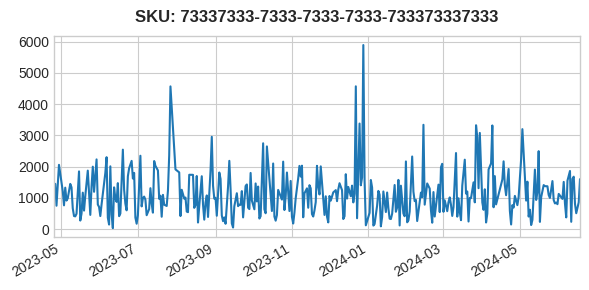

In [336]:
sample_sku_df = sorted_sku
plot_by_SKUs(sample_sku_df, pivot_df1)

sample_sku_df = sorted_sku[0:1]

In [291]:
def mape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [292]:
sample_df1 = pivot_df1.T[sample_sku_df].reset_index()
sample_df1.drop(sample_df1.tail(1).index, inplace=True)
sample_df1.columns = ['month', 'qty']
sample_df1['month'] = pd.to_datetime(sample_df1['month'], infer_datetime_format = True)
sample_df1 = sample_df1.set_index(['month'])
sample_df1

,qty
month,
2023-04-25,"1,379"
2023-04-26,"1,450"
2023-04-27,749
2023-04-28,"1,432"
2023-04-29,"2,058"
...,...
2024-06-13,"1,679"
2024-06-14,811
2024-06-15,508


In [293]:
sample_df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 342 entries, 2023-04-25 to 2024-06-18
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   qty     342 non-null    object
dtypes: object(1)
memory usage: 5.3+ KB


In [294]:
sample_df1.isnull().sum()

qty    0
dtype: int64

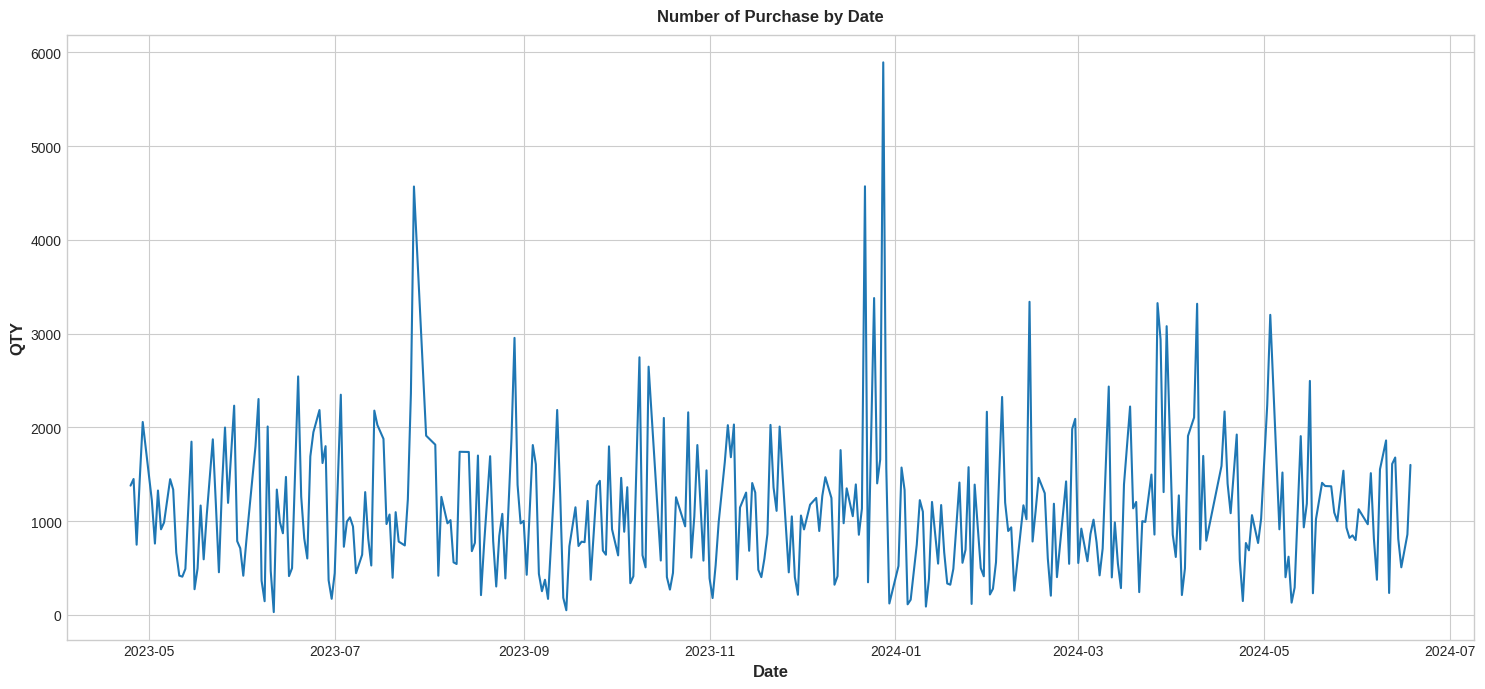

In [295]:
plt.figure(figsize = (15, 7))
plt.title("Number of Purchase by Date")
plt.xlabel('Date')
plt.ylabel('QTY')
plt.plot(sample_df1)
plt.show()

### <center> Rolling Statistics

A rolling average is a great way to visualize how the dataset is trending. As the dataset provides counts by month, a window size of 12 will give the annual rolling average.

this plot include the rolling standard deviation to see how much the data varies from the rolling average.

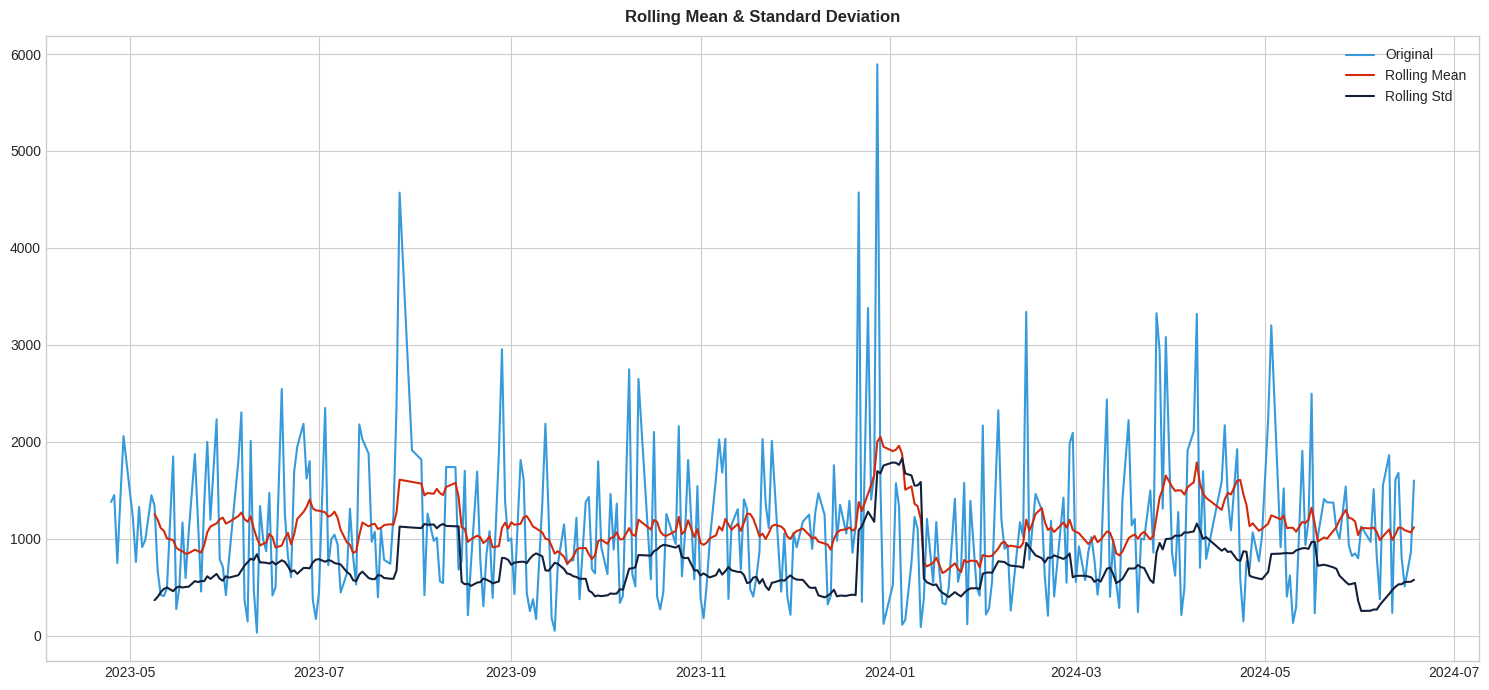

In [296]:
#Determine rolling statistics
sample_df1["rolling_avg"] = sample_df1["qty"].rolling(window = 12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
sample_df1["rolling_std"] = sample_df1["qty"].rolling(window = 12).std()

#Plot rolling statistics
plt.figure(figsize = (15, 7))
plt.plot(sample_df1["qty"], color = '#379BDB', label = 'Original')
plt.plot(sample_df1["rolling_avg"], color = '#D22A0D', label = 'Rolling Mean')
plt.plot(sample_df1["rolling_std"], color = '#142039', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Standard Deviation')
plt.savefig(sample_sku_df[0] + '_Rolling.png', bbox_inches='tight')
plt.show(block = False)

### <center>Augmented Dickey–Fuller Test</center>

The Augmented Dickey-Fuller Test is used to determine if time-series data is stationary or not. Similar to a t-test, let set a significance level before the test and make conclusions on the hypothesis based on the resulting p-value.

<B>Null Hypothesis:</B> The data is not stationary.

<B>Alternative Hypothesis:</B> The data is stationary.

For the data to be stationary (ie. reject the null hypothesis), the ADF test should have:

- p-value <= significance level (0.01, 0.05, 0.10, etc.)

If the p-value is greater than the significance level then we can say that it is likely that the data is not stationary.

In [297]:
# Prepare dataset
sample_df1 = pivot_df1.T[sample_sku_df].reset_index()
sample_df1.drop(sample_df1.tail(1).index, inplace=True)
sample_df1.columns = ['month', 'qty']
sample_df1['month'] = pd.to_datetime(sample_df1['month'], infer_datetime_format = True)
sample_df1 = sample_df1.set_index(['month'])

### <center>SARIMA Model Selection</center>

Now let's try the same strategy as above, except let's use a SARIMA model so that can be account for seasonality.

<Figure size 640x480 with 0 Axes>

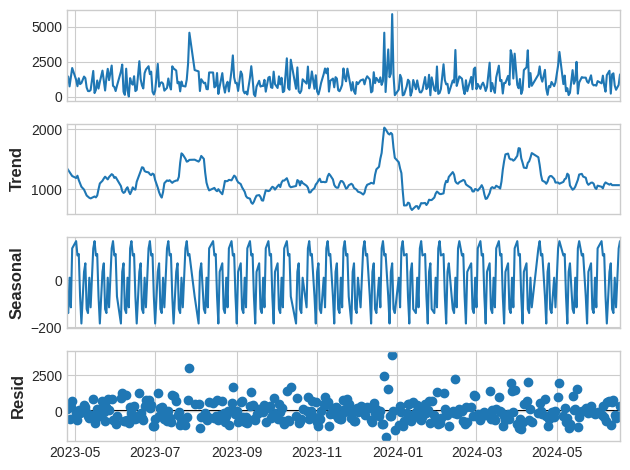

In [339]:
result = seasonal_decompose(sample_df1, model='additive', extrapolate_trend='freq', period=12)
fig = plt.figure()
fig = result.plot()
fig.savefig(sample_sku_df[0] + '_seasonal_decompose.png', bbox_inches='tight')

In [299]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(sample_df1['qty'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                -17
p-value                         0
#Lags Used                      0
Number of Observations Used   341
Critical Value (1%)            -3
Critical Value (5%)            -3
Critical Value (10%)           -3
dtype: float64


In [300]:
result = adfuller(sample_df1.qty.dropna())
print(f'ADF Statistics:{result[0]}')
print(f'p-value:{result[1]}')

ADF Statistics:-16.529620525081807
p-value:2.02918091040332e-29


The p-value is higher than 0.05. This means that the time serie is non stationary with a confidence of 95%. Then check if with a one step differentiation, the time serie become stationary (in terms of a trendless time series).

In [301]:
result2 = adfuller(sample_df1.qty.diff().dropna())
print(f'ADF Statistics:{result2[0]}')
print(f'p-value:{result2[1]}')

ADF Statistics:-10.687158371032323
p-value:3.8072124923269656e-19


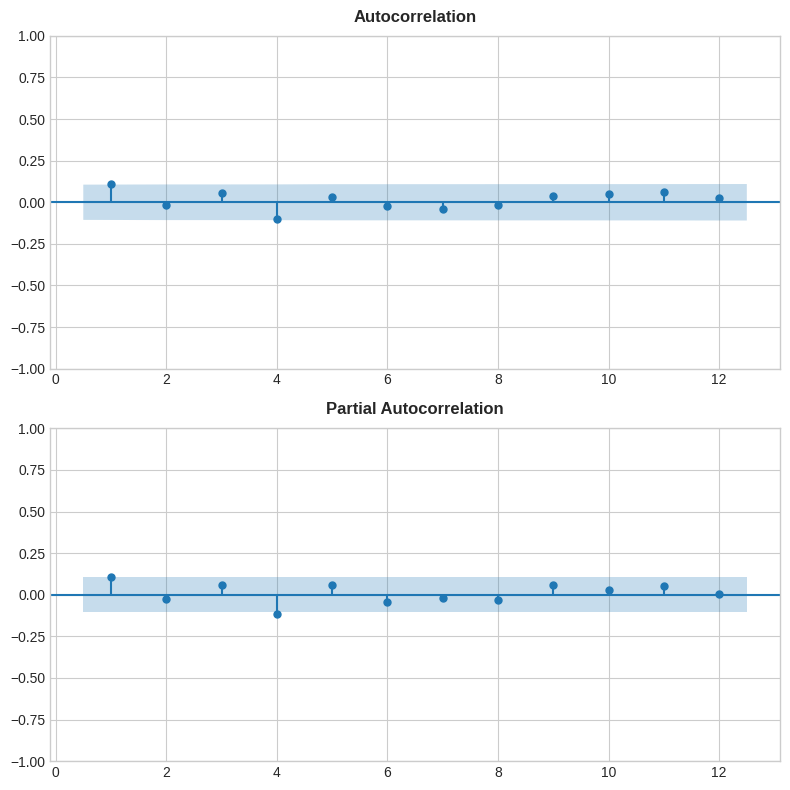

In [302]:
# @title ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (8, 8))

plot_acf(sample_df1, lags = 12, zero = False, ax = ax1)
plot_pacf(sample_df1, lags = 12, zero = False, ax = ax2)
plt.savefig(sample_sku_df[0] + '_acf_pacf.png', bbox_inches='tight')
plt.show()

In [303]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = pm.auto_arima(sample_df1, start_p = 1, start_q = 1,
                        max_p = 3, max_q = 3,
                        m = 12, # 12 is the frequncy of the cycle
                        seasonal = True, # set to seasonal
                        d = 1,
                        D = 1, # order of the seasonal differencing
                        trace = True,
                        error_action = 'ignore',
                        start_P = 1, start_Q = 1,
                        max_P = 2, max_Q = 2,
                        information_criterion = 'aic',
                        stepwise = True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=3.51 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5721.948, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5555.627, Time=0.82 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.02 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5652.599, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5537.445, Time=3.67 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=4.06 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.25 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5616.683, Time=0.48 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=5494.111, Time=3.01 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=5517.325, Time=1.39 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=10.52 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.69 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=5488.455, Time=3.15 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=5512.

### SARIMA (3,1,0)(2,1,0)[12]   : AIC=5488.455 - intercept   : AIC=5490.458

In [304]:
model1 = SARIMAX(sample_df1.astype(float), order = (3, 1, 0), seasonal_order = (2, 1, 0, 12))
SARIMA_model1 = model1.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [305]:
SARIMA_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                qty   No. Observations:                  342
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2738.228
Date:                            Tue, 18 Jun 2024   AIC                           5488.455
Time:                                    15:19:22   BIC                           5511.231
Sample:                                         0   HQIC                          5497.541
                                            - 342                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6919      0.050    -13.947      0.000      -0.789      -0.595
ar.L2         -0.4568      0.059     -7.727      0.000      -0.573      -0.341
ar.L3         -0.1517      0.057     -2.651      0.008      -0.264      -0.040
ar.S.L12      -0.6523      0.048    -13.564      0.000      -0.747      -0.558
ar.S.L24      -0.2786      0.049     -5.676      0.000      -0.375      -0.182
sigma2      9.833e+05   5.74e+04     17.120      0.000    8.71e+05     1.1e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.66   Jarque-Bera (JB):                56.61
Prob(Q):                              0.42   Prob(JB):                         0.00
Heteroskedasticity (H):               1.34   Skew:                             0.39
Prob(H) (two-sided):                  0.12   Kurtosis:                         4.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

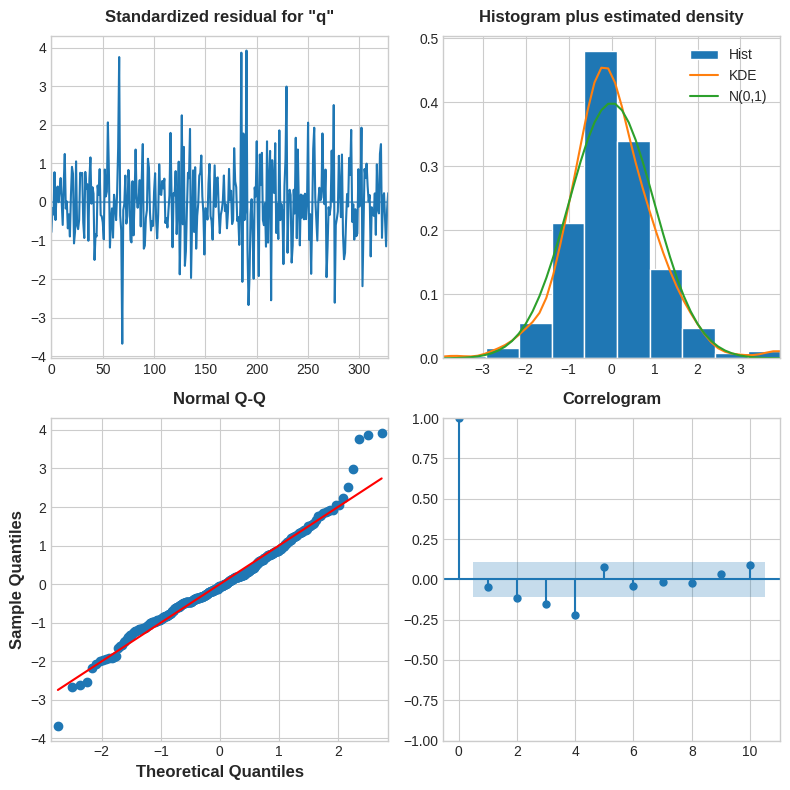

In [306]:
# @title Create the 4 diagostics plots
SARIMA_model1.plot_diagnostics(figsize = (8, 8))
plt.savefig(sample_sku_df[0] + '_model1_diag.png', bbox_inches='tight')
plt.show()

In [307]:
# All the 4 plots indicates a good fit of the SARIMA model on the given time serie.
# Create a vector that will host the predictions
prediction1 = SARIMA_model1.get_prediction(start = -12)
mean_prediction1 = prediction1.predicted_mean
mean_prediction1 = mean_prediction1.rename("prediction1")

In [308]:
# Get the confidence intervals from the sarima prediction
confi_int_p1 = prediction1.conf_int()
lower_limits_p1 = confi_int_p1.iloc[:, 0]
upper_limits_p1 = confi_int_p1.iloc[:, 1]

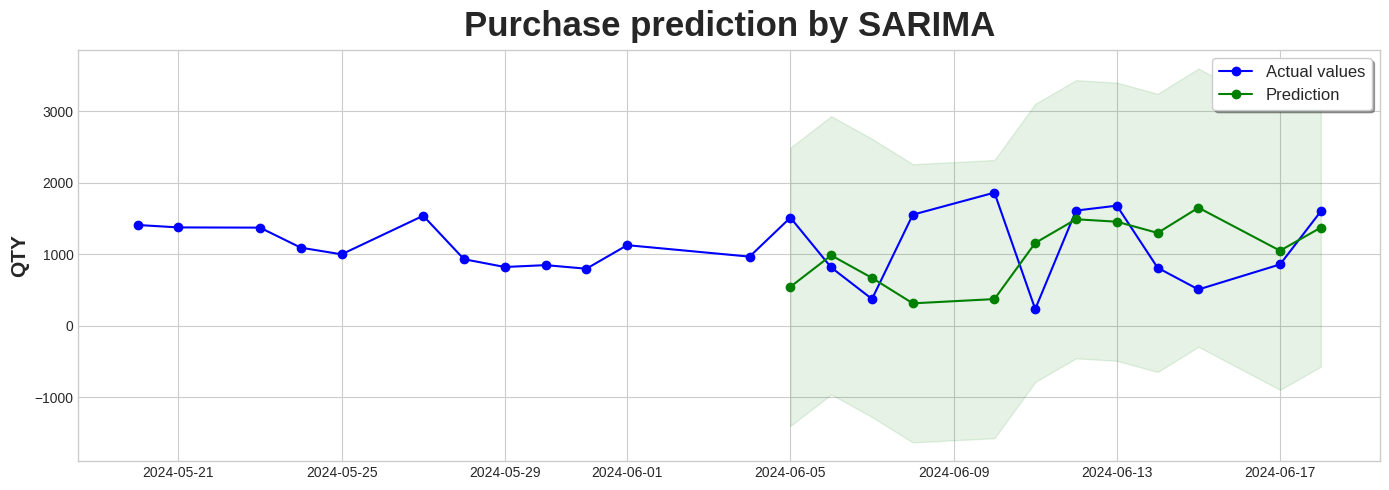

In [309]:
plt.figure(figsize = (14, 5))
plt.title("Purchase prediction by SARIMA", fontsize = 25)

plt.plot(sample_df1[-24:].index, sample_df1[-24:].values, label = 'Actual values', color = "blue", marker = "o")

plt.plot(mean_prediction1[-24:].index, mean_prediction1[-24:].values, label = 'Prediction', color = "green", marker = "o")
plt.fill_between(mean_prediction1[-24:].index, lower_limits_p1, upper_limits_p1, alpha = 0.1, color = "green")

plt.legend(fontsize = 12, fancybox = True, shadow = True, frameon = True)
plt.ylabel('QTY', fontsize = 15)
plt.savefig(sample_sku_df[0] + '_model1_predict.png', bbox_inches='tight')
plt.show()

In [310]:
mape_sarima1 = mape(sample_df1.iloc[-12:, 0], mean_prediction1)
print(f"MAPE OF LSTM MODEL : {mape_sarima1:.2f} %")

MAPE OF LSTM MODEL : 88.35 %


In [311]:
rmse_sarima1 = sqrt(mean_squared_error(sample_df1[-12:].values, mean_prediction1.values))
print(f"RMSE OF LSTM MODEL : {rmse_sarima1:.2f}")

RMSE OF LSTM MODEL : 782.43


### SARIMA(2,1,0)(2,1,0)[12] : AIC=5494.111

In [312]:
model2 = SARIMAX(sample_df1.astype(float), order = (2, 1, 0), seasonal_order = (2, 1, 0, 12))
SARIMA_model2 = model2.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [313]:
SARIMA_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                qty   No. Observations:                  342
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2742.056
Date:                            Tue, 18 Jun 2024   AIC                           5494.111
Time:                                    15:19:31   BIC                           5513.092
Sample:                                         0   HQIC                          5501.683
                                            - 342                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6371      0.043    -14.988      0.000      -0.720      -0.554
ar.L2         -0.3599      0.040     -8.930      0.000      -0.439      -0.281
ar.S.L12      -0.6516      0.048    -13.580      0.000      -0.746      -0.558
ar.S.L24      -0.2745      0.051     -5.427      0.000      -0.374      -0.175
sigma2      1.007e+06   6.01e+04     16.744      0.000    8.89e+05    1.12e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.05   Jarque-Bera (JB):                40.59
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):               1.30   Skew:                             0.22
Prob(H) (two-sided):                  0.16   Kurtosis:                         4.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

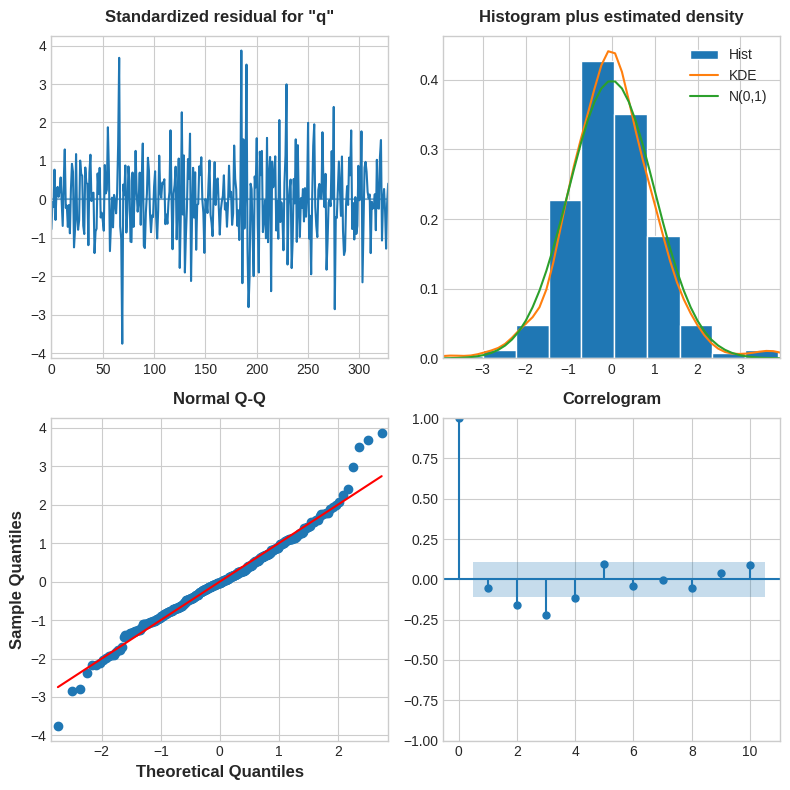

In [314]:
# @title Create the 4 diagostics plots
SARIMA_model2.plot_diagnostics(figsize = (8, 8))
plt.savefig(sample_sku_df[0] + '_model2_diag.png', bbox_inches='tight')
plt.show()

In [315]:
# All the 4 plots indicates a good fit of the SARIMA model on the given time serie.
# Create a vector that will host the predictions
prediction2 = SARIMA_model2.get_prediction(start = -12)
mean_prediction2 = prediction2.predicted_mean
mean_prediction2 = mean_prediction2.rename("prediction2")

In [316]:
# Get the confidence intervals from the sarima prediction
confi_int_p2 = prediction2.conf_int()
lower_limits_p2 = confi_int_p2.iloc[:, 0]
upper_limits_p2 = confi_int_p2.iloc[:, 1]

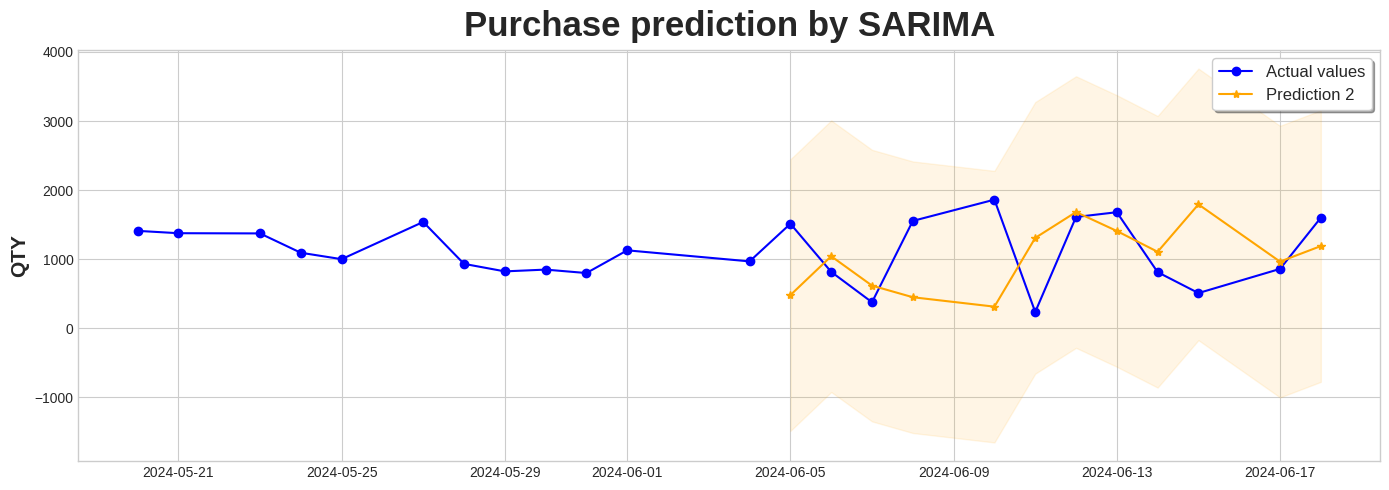

In [317]:
plt.figure(figsize = (14, 5))
plt.title("Purchase prediction by SARIMA", fontsize = 25)

plt.plot(sample_df1[-24:].index, sample_df1[-24:].values, label = 'Actual values', color = "blue", marker = "o")

plt.plot(mean_prediction2[-24:].index, mean_prediction2[-24:].values, label = 'Prediction 2', color = "orange", marker = "*")
plt.fill_between(mean_prediction2[-24:].index, lower_limits_p2, upper_limits_p2, alpha = 0.1, color = "orange")

plt.legend(fontsize = 12, fancybox = True, shadow = True, frameon = True)
plt.ylabel('QTY', fontsize = 15)
plt.savefig(sample_sku_df[0] + '_model2_predict.png', bbox_inches='tight')
plt.show()

In [318]:
mape_sarima2 = mape(sample_df1.iloc[-12:, 0], mean_prediction2)
print(f"MAPE OF LSTM MODEL : {mape_sarima2:.2f} %")

MAPE OF LSTM MODEL : 93.43 %


In [319]:
rmse_sarima2 = sqrt(mean_squared_error(sample_df1[-12:].values, mean_prediction2.values))
print(f"RMSE OF LSTM MODEL : {rmse_sarima2:.2f}")

RMSE OF LSTM MODEL : 813.86


### SARIMA(3,1,0)(1,1,0)[12] : AIC=5512.435

In [320]:
model3 = SARIMAX(sample_df1.astype(float), order = (3, 1, 0), seasonal_order = (1, 1, 0, 12))
SARIMA_model3 = model3.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [321]:
SARIMA_model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                qty   No. Observations:                  342
Model:             SARIMAX(3, 1, 0)x(1, 1, 0, 12)   Log Likelihood               -2751.217
Date:                            Tue, 18 Jun 2024   AIC                           5512.435
Time:                                    15:19:36   BIC                           5531.415
Sample:                                         0   HQIC                          5520.006
                                            - 342                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6715      0.050    -13.556      0.000      -0.769      -0.574
ar.L2         -0.4303      0.060     -7.152      0.000      -0.548      -0.312
ar.L3         -0.1442      0.060     -2.418      0.016      -0.261      -0.027
ar.S.L12      -0.5075      0.038    -13.182      0.000      -0.583      -0.432
sigma2      1.069e+06   6.49e+04     16.459      0.000    9.41e+05     1.2e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.60   Jarque-Bera (JB):                34.01
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                             0.16
Prob(H) (two-sided):                  0.28   Kurtosis:                         4.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

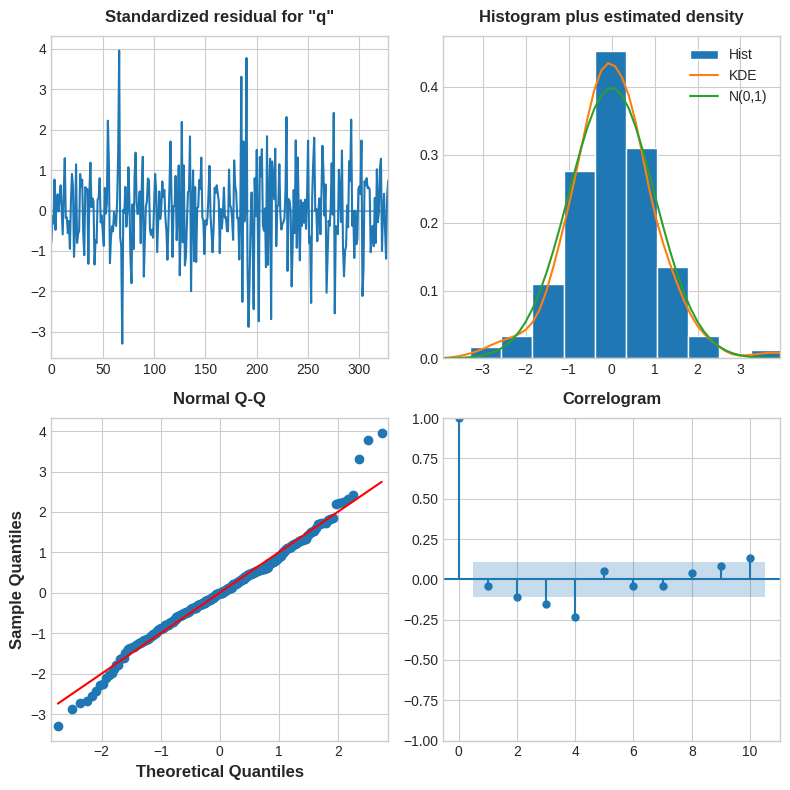

In [322]:
# @title Create the 4 diagostics plots
SARIMA_model3.plot_diagnostics(figsize = (8, 8))
plt.savefig(sample_sku_df[0] + '_model3_diag.png', bbox_inches='tight')
plt.show()

In [323]:
# All the 4 plots indicates a good fit of the SARIMA model on the given time serie.
# Create a vector that will host the predictions
prediction3 = SARIMA_model3.get_prediction(start = -12)
mean_prediction3 = prediction3.predicted_mean
mean_prediction3 = mean_prediction3.rename("prediction3")

In [324]:
# Get the confidence intervals from the sarima prediction
confi_int_p3 = prediction3.conf_int()
lower_limits_p3 = confi_int_p3.iloc[:, 0]
upper_limits_p3 = confi_int_p3.iloc[:, 1]

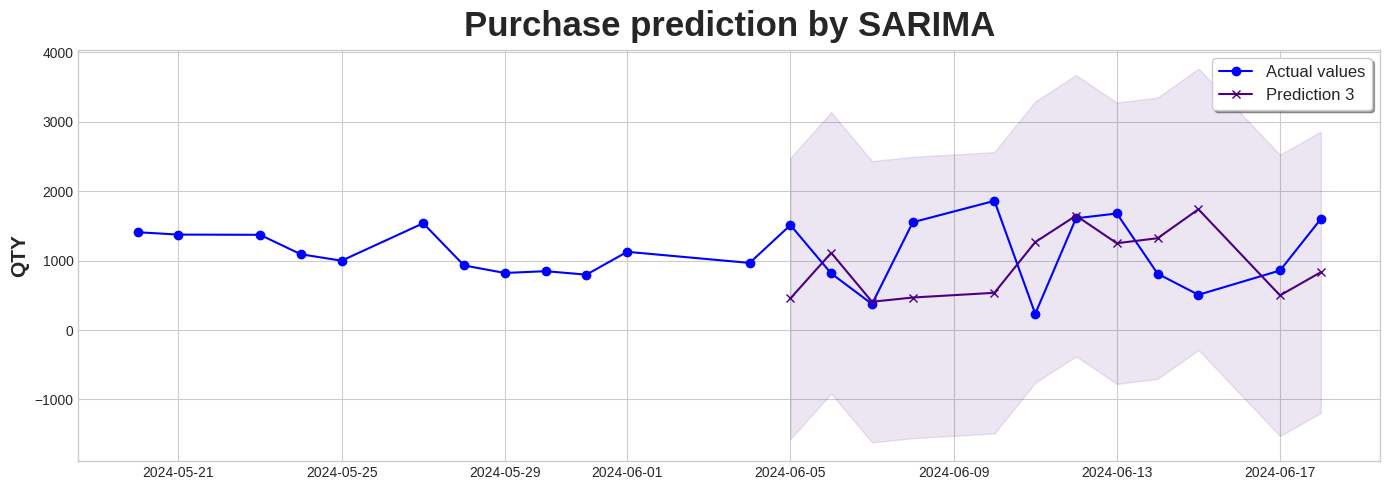

In [325]:
plt.figure(figsize = (14, 5))
plt.title("Purchase prediction by SARIMA", fontsize = 25)

plt.plot(sample_df1[-24:].index, sample_df1[-24:].values, label = 'Actual values', color = "blue", marker = "o")

plt.plot(mean_prediction3[-24:].index, mean_prediction3[-24:].values, label = 'Prediction 3', color = "indigo", marker = "x")
plt.fill_between(mean_prediction3[-24:].index, lower_limits_p3, upper_limits_p3, alpha = 0.1, color = "indigo")

plt.legend(fontsize = 12, fancybox = True, shadow = True, frameon = True)
plt.ylabel('QTY', fontsize = 15)
plt.savefig(sample_sku_df[0] + '_model3_predict.png', bbox_inches='tight')
plt.show()

In [326]:
mape_sarima3 = mape(sample_df1.iloc[-12:, 0], mean_prediction3)
print(f"MAPE OF LSTM MODEL : {mape_sarima3:.2f} %")

MAPE OF LSTM MODEL : 93.37 %


In [327]:
rmse_sarima3 = sqrt(mean_squared_error(sample_df1[-12:].values, mean_prediction3.values))
print(f"RMSE OF LSTM MODEL : {rmse_sarima3:.2f}")

RMSE OF LSTM MODEL : 810.41


# Results Sumamry

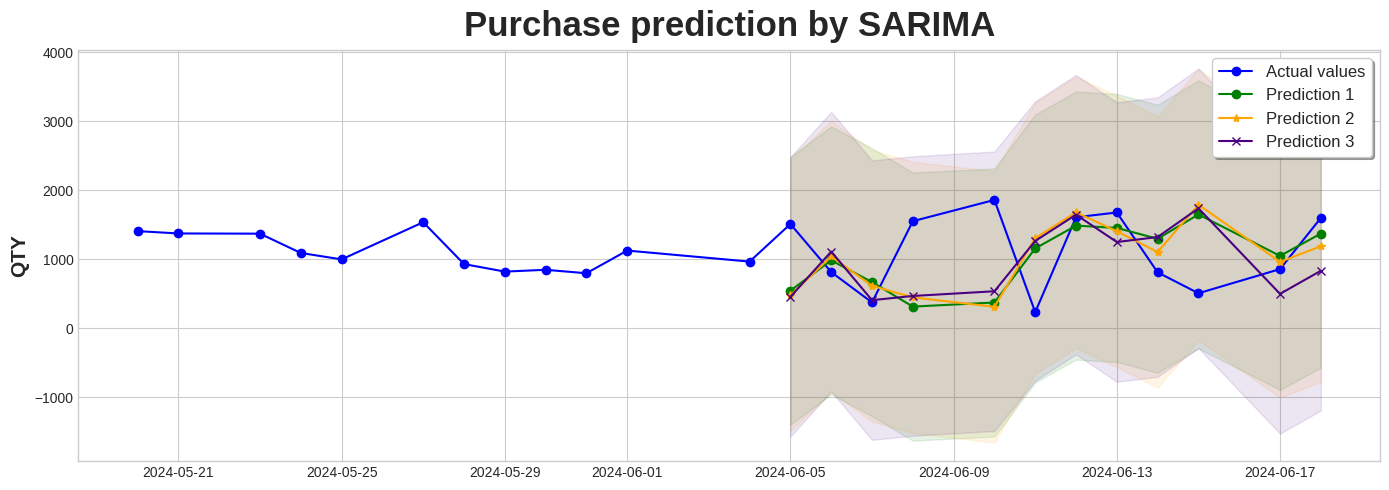

In [328]:
plt.figure(figsize = (14, 5))
plt.title("Purchase prediction by SARIMA", fontsize = 25)

plt.plot(sample_df1[-24:].index, sample_df1[-24:].values, label = 'Actual values', color = "blue", marker = "o")

plt.plot(mean_prediction1[-24:].index, mean_prediction1[-24:].values, label = 'Prediction 1', color = "green", marker = "o")
plt.fill_between(mean_prediction1[-24:].index, lower_limits_p1, upper_limits_p1, alpha = 0.1, color = "green")

plt.plot(mean_prediction2[-24:].index, mean_prediction2[-24:].values, label = 'Prediction 2', color = "orange", marker = "*")
plt.fill_between(mean_prediction2[-24:].index, lower_limits_p2, upper_limits_p2, alpha = 0.1, color = "orange")

plt.plot(mean_prediction3[-24:].index, mean_prediction3[-24:].values, label = 'Prediction 3', color = "indigo", marker = "x")
plt.fill_between(mean_prediction3[-24:].index, lower_limits_p3, upper_limits_p3, alpha = 0.1, color = "indigo")

plt.legend(fontsize = 12, fancybox = True, shadow = True, frameon = True)
plt.ylabel('QTY', fontsize = 15)
plt.savefig(sample_sku_df[0] + '_summary.png', bbox_inches='tight')
plt.show()

สรุปได้ว่าควรใช้
Best model:

1.   SARIMA(3,1,0)(2,1,0) [12]
2.   SARIMA(2,1,0)(2,1,0) [12]
3.   SARIMA(3,1,0)(1,1,0) [12]

Model ที่ 1-2 ดีกว่า และดีกว่า การใช้ datapoint รายเดือน